# SAB: Scalable Analysis of Bayesian Networks

We run experiments on some sample topologies.

In [1]:
import concurrent.futures
import os
import time

import networkx as nx
import numpy as np
import pandas as pd
import tracemalloc

from causalnex.structure.notears import from_pandas
from causalnex.structure import StructureModel
from networkx.classes import DiGraph
from sklearn.preprocessing import LabelEncoder
from typing import List, Tuple, Dict
from matplotlib import pyplot

# SAB Pipeline

In [2]:
class TopologyLabel:
    def __init__(self, nid: int, collider=False, chain=False, fork=False):
        self.nid : int = nid
        self.collider : bool = collider
        self.chain : bool = chain
        self.fork : bool = fork

    def __str__(self):
        return (f"{self.nid}: {{collider = {self.collider}, chain = {self.chain}, "
                f"fork = {self.fork}}}")

    def __repr__(self):
        return str(self)

def is_csv_file(file_path):
  return os.path.splitext(file_path)[1].lower() == '.csv'

def preprocessor(dataset: str, delim=",") -> Tuple[StructureModel, float, float, float]:
    assert is_csv_file(dataset)
    start = time.perf_counter()
    data_pd = pd.read_csv(dataset, delimiter=delim)
    io_time = time.perf_counter() - start

    start = time.perf_counter()
    non_numeric_columns = list(data_pd.select_dtypes(exclude=[np.number]).columns)
    le = LabelEncoder()

    for col in non_numeric_columns:
        data_pd[col] = le.fit_transform(data_pd[col])
    enc_time = time.perf_counter() - start

    start = time.perf_counter()
    s_model = from_pandas(data_pd, w_threshold=0.8)
    nt_time = time.perf_counter() - start
    return s_model, io_time, enc_time, nt_time

def relabel(s_model: StructureModel) -> Tuple[DiGraph, List[int]]:
    mapping = dict()
    inv_mapping = []
    label = 0
    s = sorted(s_model.nodes)
    for s_node in s:
        mapping[s_node] = label
        label += 1
        inv_mapping.append(s_node)
    return nx.relabel_nodes(s_model, mapping), inv_mapping

def sab_threaded(dag: DiGraph, result : Dict[str, TopologyLabel], tid: int, n_threads: int) -> None:
    idx = tid
    n_nodes = len(dag.nodes)
    nodes = list(dag.nodes)
    while idx < n_nodes:
        v = nodes[idx]
        i_d = dag.in_degree(v)
        o_d = dag.out_degree(v)
        if i_d > 1:
            result[v].collider = True
        elif i_d == 1 and o_d >= 1:
            result[v].chain = True
        if o_d > 1:
            result[v].fork = True
        idx += n_threads

def sab_core(dag: DiGraph, parallel=False, n_threads=8) -> Tuple[Dict[str, TopologyLabel], float]:
    start = time.perf_counter()
    assert nx.is_directed_acyclic_graph(dag)
    result : Dict[str, TopologyLabel] = {}
    for v in dag.nodes:
        result[v] = TopologyLabel(v)

    if not parallel:
        sab_threaded(dag, result, 0, 1)
    else:
        num_threads = min(n_threads, len(dag.nodes))
        with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as sab_executor:
            for tid in range(num_threads):
                sab_executor.submit(sab_threaded, dag, result, tid, num_threads)
    alg_time = time.perf_counter() - start
    return result, alg_time

def sab(dataset: str, delim=",", parallel=False, n_threads=8) -> Tuple[Dict[str, TopologyLabel], float, float, float, float, float]:
    tracemalloc.start()
    initial_mem, _ = tracemalloc.get_traced_memory()
    assert n_threads <= len(os.sched_getaffinity(0)), "Number of threads must be smaller than the number of CPU cores available to the process"
    # preprocessing
    assert is_csv_file(dataset) and os.path.exists(dataset)
    dag, io_time, enc_time, nt_time = preprocessor(dataset, delim=delim)
    result, alg_time = sab_core(dag, parallel, n_threads)
    _, peak_mem = tracemalloc.get_traced_memory()
    tracemalloc.stop()
    return result, io_time, enc_time, nt_time, alg_time, ((peak_mem - initial_mem) / (1024 ** 2))

## Graph Plotting

In [ ]:
d_str = "datasets/student-por.csv"
data = pd.read_csv('datasets/student-por.csv')
drop_col = ['school','sex','age','Mjob', 'Fjob','reason','guardian']
data = data.drop(columns=drop_col)
data.head(5)

In [7]:
psm, io_t, enc_t, nt_t = preprocessor(d_str)

In [ ]:
s_psm = psm.get_largest_subgraph()
fig, axs = pyplot.subplots(figsize=(7, 5), dpi=300)
pos = nx.spring_layout(s_psm, k=12, iterations=30)
nx.draw_networkx(s_psm, pos, font_color="black", node_color="lightgrey", node_size=800)
pyplot.savefig("uci_perf.pdf")
pyplot.show()

# Evaluation

In [8]:
trials = 1
experiments = 4
i_t_s = []
e_t_s = []
n_t_s = []
a_t_s = []
m_t_s = []

for exr in range(experiments):
    i_t_s.append(0)
    e_t_s.append(0)
    n_t_s.append(0)
    a_t_s.append(0)
    m_t_s.append(0)

## Runtime and Overhead Measurements

In [10]:
v_d = []
delimiters = [",", ","]
d_str_s = ["datasets/heart_cleveland_upload.csv", "datasets/student-por.csv"]
for dt, dm in zip(d_str_s, delimiters):
    n_thr = 4
    for exr in range(experiments):
        if exr == 0:
            for trial in range(trials):
                _, i_t, e_t, n_t, a_t, m_t = sab(dt, delim=dm)
                i_t_s[exr] += i_t / trials
                e_t_s[exr] += e_t / trials
                n_t_s[exr] += n_t / trials
                a_t_s[exr] += a_t / trials
                m_t_s[exr] += m_t / trials
        else:
            for trial in range(trials):
                _, i_t, e_t, n_t, a_t, m_t = sab(dt, delim=dm, parallel=True, n_threads=n_thr)
                i_t_s[exr] += i_t / trials
                e_t_s[exr] += e_t / trials
                n_t_s[exr] += n_t / trials
                a_t_s[exr] += a_t / trials
                m_t_s[exr] += m_t / trials
            n_thr *= 2
    print(i_t_s, e_t_s, n_t_s, a_t_s, m_t_s)
    v_d.append((i_t_s.copy(), e_t_s.copy(), n_t_s.copy(), a_t_s.copy(), m_t_s.copy()))
    for exr in range(experiments):
        i_t_s[exr] = 0
        e_t_s[exr] = 0
        n_t_s[exr] = 0
        a_t_s[exr] = 0

[0.008429802022874355, 0.0036756149493157864, 0.0038990252651274204, 0.003855575807392597] [0.0002979305572807789, 0.0001328699290752411, 0.00014211097732186317, 0.000135740265250206] [16.34786899993196, 16.41595134837553, 16.387644288130105, 16.55898780329153] [0.00018792971968650818, 0.0016318419948220253, 0.0017160726711153984, 0.002175142988562584] [2.168545722961426, 1.8824071884155273, 1.8831844329833984, 1.8823413848876953]
[0.0064910599030554295, 0.010202880017459393, 0.007438721135258675, 0.007122900802642107] [0.0077454810962080956, 0.01154346065595746, 0.009060109965503216, 0.008733781054615974] [84.98926830803975, 83.93401745008305, 75.67994042718783, 92.18490037415177] [0.00038814032450318336, 0.001127759926021099, 0.0014374800957739353, 0.0022547300904989243] [3.463468551635742, 3.1736602783203125, 3.1722936630249023, 3.173219680786133]


## Synthetic DAGs

## Bar Plots

In [27]:
def grouped_bar_plots(data_x: List[str],
                      data_y: Dict[str, List[float]], y_label: str,
                      title: str, f_name: str, lloc='upper right', bl=True) -> None:
    x = np.arange(len(data_x))  # the label locations
    width = 0.1875  # the width of the bars
    multiplier = 0

    b_fig, ax = pyplot.subplots(layout='constrained')

    for attribute, measurement in data_y.items():
        offset = width * multiplier
        rects = ax.bar(x + offset, measurement, width, label=attribute)
        if bl:
            ax.bar_label(rects, padding=3, fmt='%.2f')
        multiplier += 1

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x + 0.4, data_x)
    ax.legend(loc=lloc, ncols=2)
    pyplot.savefig(f_name)
    pyplot.show()

In [31]:
x_labels = ["HDCUD", "USPD"]
y_labels = ["seqSAB", "SAB(4)", "SAB(8)", "SAB(16)"]
d1_a_t = v_d[0][3]
d2_a_t = v_d[1][3]

# normalize to ms
s_d = [d1_a_t[0] * 1000, d2_a_t[0] * 1000]
s_4 = [d1_a_t[1] * 1000, d2_a_t[1] * 1000]
s_8 = [d1_a_t[2] * 1000, d2_a_t[2] * 1000]
s_16 = [d1_a_t[3] * 1000, d2_a_t[3] * 1000]

In [12]:
print(s_d)

[1.19011290371418, 0.34351134672760963]


### Runtime

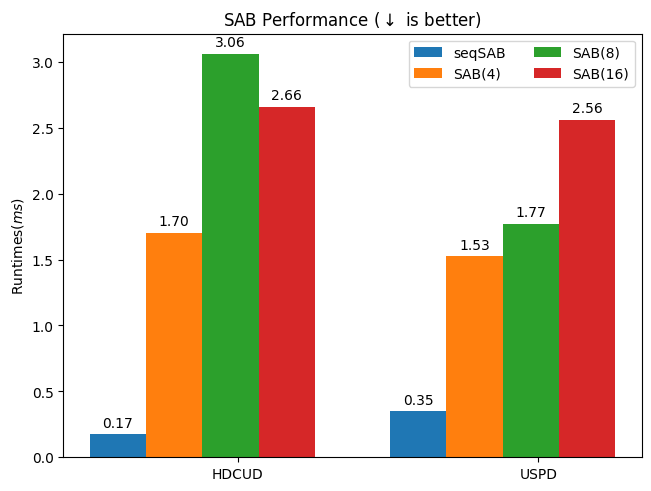

In [18]:
d_y = {
    y_labels[0]: s_d,
    y_labels[1]: s_4,
    y_labels[2]: s_8,
    y_labels[3]: s_16,
}

grouped_bar_plots(x_labels, d_y, r"Runtimes($ms$)", r"SAB Performance ($\downarrow$ is better)", "sab_perf.pdf")

### Transformation Overhead

In [32]:
d1_a_t = v_d[0][1]
d2_a_t = v_d[1][1]

# normalize to ms
s_d = [d1_a_t[0] * 1000, d2_a_t[0] * 1000]
s_4 = [d1_a_t[1] * 1000, d2_a_t[1] * 1000]
s_8 = [d1_a_t[2] * 1000, d2_a_t[2] * 1000]
s_16 = [d1_a_t[3] * 1000, d2_a_t[3] * 1000]

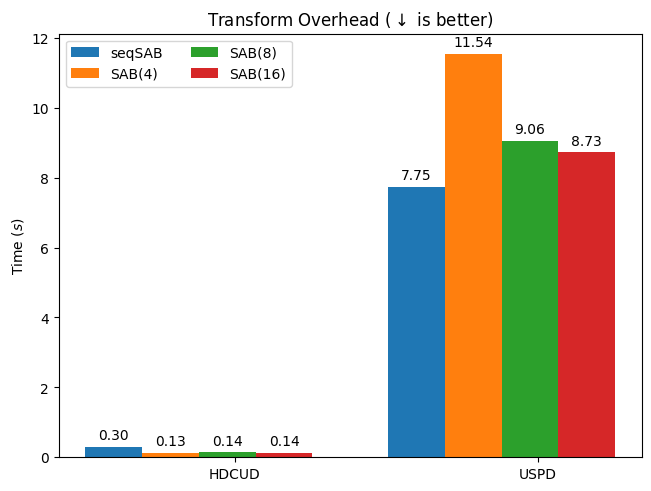

In [33]:
d_y = {
    y_labels[0]: s_d,
    y_labels[1]: s_4,
    y_labels[2]: s_8,
    y_labels[3]: s_16,
}

grouped_bar_plots(x_labels, d_y, r"Time ($s$)", r"Transform Overhead ($\downarrow$ is better)", "sab_t_o.pdf", lloc='upper left')

### DAG Generation

In [34]:
d1_a_t = v_d[0][2]
d2_a_t = v_d[1][2]

# normalize to ms
s_d = [d1_a_t[0], d2_a_t[0]]
s_4 = [d1_a_t[1], d2_a_t[1]]
s_8 = [d1_a_t[2], d2_a_t[2]]
s_16 = [d1_a_t[3], d2_a_t[3]]

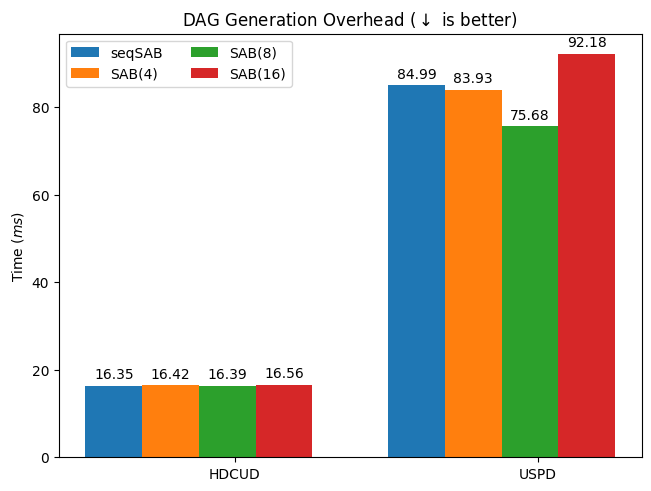

In [35]:
d_y = {
    y_labels[0]: s_d,
    y_labels[1]: s_4,
    y_labels[2]: s_8,
    y_labels[3]: s_16,
}

grouped_bar_plots(x_labels, d_y, r"Time ($ms$)", r"DAG Generation Overhead ($\downarrow$ is better)", "sab_g_o.pdf", lloc='upper left')

### Memory Consumption

In [36]:
d1_a_t = v_d[0][4]
d2_a_t = v_d[1][4]

# normalize to ms
s_d = [d1_a_t[0], d2_a_t[0]]
s_4 = [d1_a_t[1], d2_a_t[1]]
s_8 = [d1_a_t[2], d2_a_t[2]]
s_16 = [d1_a_t[3], d2_a_t[3]]

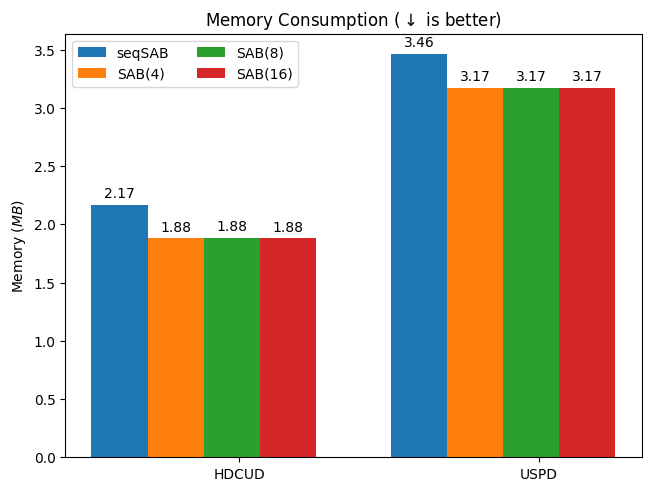

In [37]:
d_y = {
    y_labels[0]: s_d,
    y_labels[1]: s_4,
    y_labels[2]: s_8,
    y_labels[3]: s_16,
}

grouped_bar_plots(x_labels, d_y, r"Memory ($MB$)", r"Memory Consumption ($\downarrow$ is better)", "sab_m_o.pdf", lloc='upper left')

## Robustness

In [23]:
trials = 1
experiments = 4
nds = [128, 256, 512]
runs = 4
r_a_t = []
for exr in range(experiments):
        r_a_t.append(0)
r_v_d = []
for nd in nds:
    d = np.tril(np.ones((nd, nd), dtype=int), -1)
    dg = nx.from_numpy_array(d)
    G = nx.DiGraph()
    G.add_edges_from(dg.edges)
    n_thr = 4
    for exr in range(experiments):
        if exr == 0:
            for trial in range(trials):
                _, alg_t = sab_core(G)
                r_a_t[exr] += alg_t / trials
        else:
            for trial in range(trials):
                _, alg_t = sab_core(G, parallel=True, n_threads=n_thr)
                r_a_t[exr] += alg_t / trials
            n_thr *= 2
    print(r_a_t)
    r_v_d.append(r_a_t.copy())
    for exr in range(experiments):
        r_a_t[exr] = 0

[0.0010059410706162453, 0.002038809936493635, 0.002080710604786873, 0.0030847610905766487]
[0.0033629508689045906, 0.004308161325752735, 0.004262502305209637, 0.004817960783839226]
[0.01576537499204278, 0.016565615311264992, 0.017297654878348112, 0.01714923605322838]


In [24]:
x_labels = ["HDCUD", "USPD", "RD128", "RD256", "RD512"]
y_labels = ["seqSAB", "SAB(4)", "SAB(8)", "SAB(16)"]
d1_a_t = v_d[0][3]
d2_a_t = v_d[1][3]
s_dg = r_v_d

# normalize to ms
s_d = [d1_a_t[0] * 1000, d2_a_t[0] * 1000, s_dg[0][0] * 1000, s_dg[1][0] * 1000, s_dg[2][0] * 1000]
s_4 = [d1_a_t[1] * 1000, d2_a_t[1] * 1000, s_dg[0][1] * 1000, s_dg[1][1] * 1000, s_dg[2][1] * 1000]
s_8 = [d1_a_t[2] * 1000, d2_a_t[2] * 1000, s_dg[0][2] * 1000, s_dg[1][2] * 1000, s_dg[2][2] * 1000]
s_16 = [d1_a_t[3] * 1000, d2_a_t[3] * 1000, s_dg[0][3] * 1000, s_dg[1][3] * 1000, s_dg[2][3] * 1000]

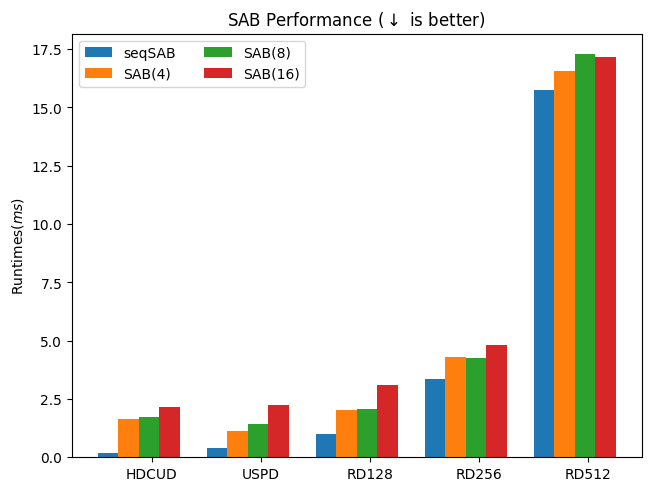

In [28]:
d_y = {
    y_labels[0]: s_d,
    y_labels[1]: s_4,
    y_labels[2]: s_8,
    y_labels[3]: s_16,
}

grouped_bar_plots(x_labels, d_y, r"Runtimes ($ms$)", r"SAB Performance ($\downarrow$ is better)", "sab_perf2.pdf", lloc='upper left', bl=False)